<div style="display: block; text-align: center">
    <h2 style='color: gold'><font color='royalblue'>Quantum walk</font> resource comparison - <font color='indigo'>Increment/Decrement approach</font> vs. <font color='blueviolet'>Nearest Neighbor approach</font></h2>
</div>

> - In the increment/decrement approach, we required two components for shifting the walker after the toss. Say when the coin toss result is HEAD, we need to move the walker right i.e.: increment its current position state $(\ket{x}=\ket{x+1})$ and move left i.e.: decrement the current position state $(\ket{x}=\ket{x-1})$ otherwise. Note that in this case, when decrementing, in case of negative numbers, the circuit outputs 2's complement numbers.
> - In contrast, nearest neighbor approach requires one.
> - In case of increment/decrement, we were repeating those those two components after each toss. However, in nearest neighbor approach, that one component is different for when the walker is on a even position state and when the walker is on an odd position state.

In [1]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, BasicAer, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import math as m

## Increment & Decrement components

> The two functions written below, _get_increment()_ and _get_decrement()_ are used to prepare the circuit for increment and decrement respectively. Later I have written another function _prepare_incdec(N)_. That function is the main driver function for the naive increment decrement quantum walk implementation. Calling _prepare_incdec(N)_ with any value for $N$ (int: number of qubits) will return the quantum circuit for increment decrement quantum walk. These two functions are used as helpers in that function.

In [19]:
def get_increment(qc):
    """
    This function is to prepare the quantum circuit for increment. The changes are not made directly to the argument.
    Parameters:
        qc (QuantumCircuit): The QuantumCircuit object from qiskit where the increment logic is to be implemented.
    Returns:
        QuantumCircuit: A QuantumCircuit object with the increment logic added to it
    """
    qc_copy = qc.copy()
    qr = qc_copy.qubits
    N = len(qr)-1    # because N-1 qubits are used to represent position space and 1 qubit for the coin 
    coin = qr[len(qr)-1]
    
    for i in range(N-1, -1, -1):
        ctrls = []
        for j in range(i): ctrls.append(j)
        ctrls.append(coin)
        qc_copy.mcx(ctrls, qr[i])
        
    return qc_copy

def get_decrement(qc):
    """
    This function is to prepare the quantum circuit for decrement. The changes are not made directly to the argument.
    Parameters:
        qc (QuantumCircuit): The QuantumCircuit object from qiskit where the decrement logic is to be implemented.
    Returns:
        QuantumCircuit: A QuantumCircuit object with the decrement logic added to it
    """
    qc_copy = qc.copy()
    qr = qc_copy.qubits
    N = len(qr)-1    # because N-1 qubits are used to represent position space and 1 qubit for the coin 
    coin = qr[len(qr)-1]
    
    for i in range(0, N):
        ctrls = []
        for j in range(i): ctrls.append(j)
        ctrls.append(coin)
        qc_copy.mcx(ctrls, qr[i])
        
    return qc_copy
    

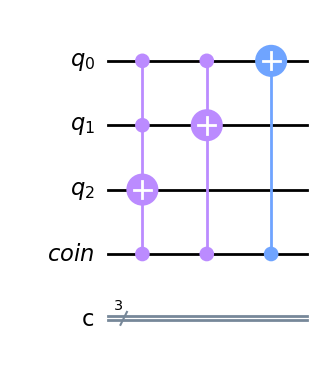

In [24]:
N = 3
qc = QuantumCircuit(QuantumRegister(N, 'q'), QuantumRegister(1, 'coin'), ClassicalRegister(N, 'c'))
increment_logic = get_increment(qc)
increment_logic.draw('mpl', style='clifford')

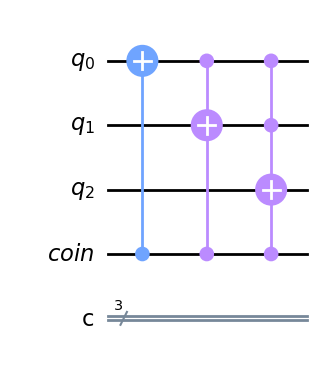

In [25]:
decrement_logic = get_decrement(qc)
decrement_logic.draw('mpl', style='clifford')

## Increment/Decrement (naive) Quantum Walk

> And here comes the main driver function for the naive quantum walk implementation as I mentioned earlier.

In [139]:
def prepare_incdec(N, verbose=False):
    coin = QuantumRegister(1, 'coin')
    nqw = QuantumCircuit(QuantumRegister(N, 'q'), coin, ClassicalRegister(N, 'c'))

    if verbose:
        state_label = '0'
        for i in range(N): state_label += '0'
        print(f'Initial state: {state_label}')
        v = Statevector.from_label(state_label)
        new = {}
    
    # ((2**N)-1)//2
    for i in range(((2**N)-1)//2):
        nqw.h(coin)    # tossing the coin
        nqw = get_increment(nqw)
        # nqw.barrier()  # done incrementing on coin toss
        nqw.x(coin)
        nqw = get_decrement(nqw)
        nqw.x(coin)
        nqw.barrier()  # done incrementing on coin toss

        if verbose:
            # this below section is to get how many steps I get after ith toss
            # this section has nothing to do with the actual walk rather it is
            # to verify the implementation's correctness ---------------------
            d = {}
            v = v.reset()
            v = v.evolve(nqw)
            x = v.to_dict()
            c = 0
            for key, value in x.items():
                if abs(value) > 1e-10:
                    d[key[1:]] = value
                    if key[1:] not in new.keys():
                        c += 1
                        new[key[1:]] = c
                        
            print(f'After {i+1} toss(es): {len(d)} states and {c} new states')
            # ----------------------------------------------------------------
    return nqw

Initial state: 00000
After 1 toss(es): 2 states and 2 new states
After 2 toss(es): 3 states and 3 new states
After 3 toss(es): 4 states and 2 new states
After 4 toss(es): 5 states and 2 new states
After 5 toss(es): 6 states and 2 new states
After 6 toss(es): 7 states and 2 new states
After 7 toss(es): 8 states and 2 new states


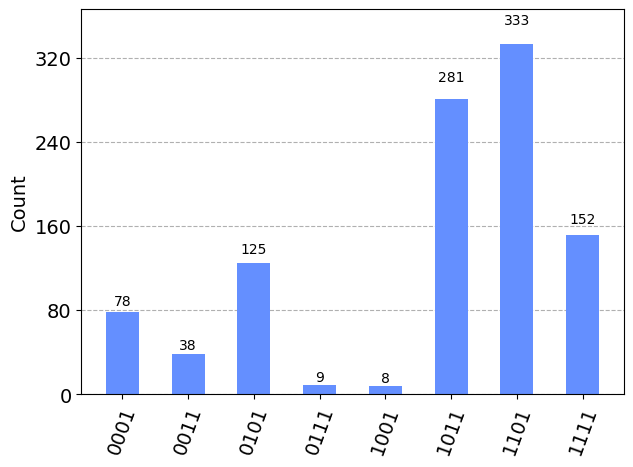

In [143]:
N = 4
nqw = prepare_incdec(N, verbose=True)
# nqw.draw('mpl', style='clifford')
nqw.measure([i for i in range(N)], [i for i in range(N)])
backend = BasicAer.get_backend('qasm_simulator')
circuit_compiled = transpile(nqw, backend)
simulator = backend.run(circuit_compiled, shots=1024)
result = simulator.result()
counts = result.get_counts(circuit_compiled)
plot_histogram(counts)

## Nearest neighbor components

> The two functions written below, _from_even()_ and _from_odd()_ are used to shift the walker from even position state and odd position state after coin toss. The plan is same as in the previous case. I have a main driver function later named _prepare_nn(N)_ which uses these two as helper.

In [104]:
def from_even(qc):
    qc_copy = qc.copy()
    qr = qc_copy.qubits
    N = len(qr)-1
    coin = qr[len(qr)-1]
    
    # qc_copy.h(coin)
    qc_copy.x(qr[0])
    for i in range(N-2, 0, -1):
        ctrls = []
        for j in range(1, i): ctrls.append(j)
        ctrls.append(coin)
        qc_copy.mcx(ctrls, qr[i])
    ctrls = []
    for i in range(1, N-1): ctrls.append(qr[i])
    ctrls.append(coin)
    qc_copy.mcx(ctrls, qr[N-1])
    return qc_copy

def from_odd(qc):
    qc_copy = qc.copy()
    qr = qc_copy.qubits
    N = len(qr)-1
    coin = qr[len(qr)-1]
    
    # qc_copy.h(coin)
    # qc_copy.x(coin)
    qc_copy.x(qr[0])

    ctrls = []
    for i in range(1, N-1): ctrls.append(qr[i])
    ctrls.append(coin)
    qc_copy.mcx(ctrls, qr[N-1])
    for i in range(1, N-1):
        ctrls = []
        for j in range(1, i): ctrls.append(j)
        ctrls.append(coin)
        qc_copy.mcx(ctrls, qr[i])
    # qc_copy.x(coin)
    return qc_copy

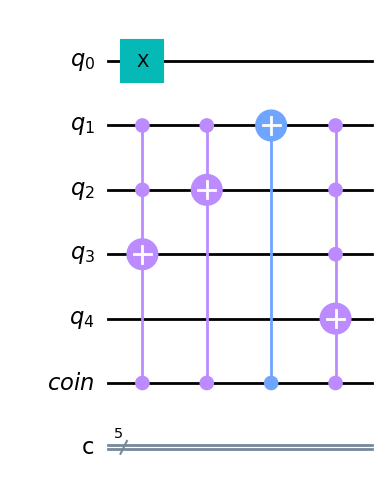

In [105]:
N = 5
qc = QuantumCircuit(QuantumRegister(N, 'q'), QuantumRegister(1, 'coin'), ClassicalRegister(N, 'c'))
even_logic = from_even(qc)
even_logic.draw('mpl', style='clifford')

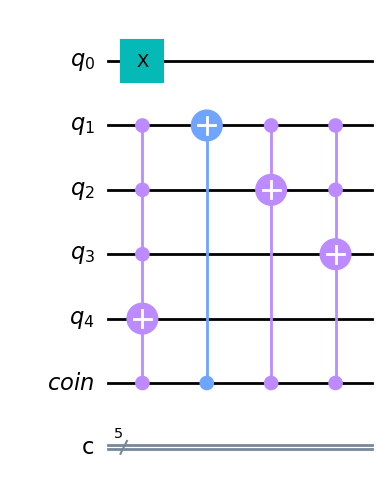

In [106]:
odd_logic = from_odd(qc)
odd_logic.draw('mpl', style='clifford')

## Nearest neighbor quantum walk

> Here comes the main driver function for generalized nearest neighbor quantum walk implementation.

In [155]:
def prepare_nn(N, verbose=False):
    coin = QuantumRegister(1, 'coin')
    nnqw = QuantumCircuit(QuantumRegister(N, 'q'), coin, ClassicalRegister(N, 'c'))

    if verbose:
        state_label = '0'
        for i in range(N): state_label += '0'
        print(f" Intial state: {state_label}")
        v = Statevector.from_label(state_label)
        new = {}
    
    # ((2**N)-1)//2
    for i in range(((2**N)-1)//2):
        if i%2 == 0:
            nnqw.h(coin)    # tossing the coin
            nnqw = from_even(nnqw)
            nnqw.barrier()
        else:
            nnqw.h(coin)    # tossing the coin
            nnqw.x(coin)
            nnqw = from_odd(nnqw)
            nnqw.x(coin)
            nnqw.barrier()

        if verbose:
            # this below section is to get how many steps I get after ith toss
            # this section has nothing to do with the actual walk rather it is
            # to verify the implementation's correctness ---------------------
            d = {}
            v = v.reset()
            v = v.evolve(nnqw)
            x = v.to_dict()
            c = 0
            for key, value in x.items():
                if abs(value) > 1e-10:
                    d[key[1:]] = value
                    if key[1:] not in new.keys():
                        c += 1
                        new[key[1:]] = c
                        
            print(f'After {i+1} toss(es): {len(d)} states and {c} new states')
            # ----------------------------------------------------------------
    return nnqw

 Intial state: 00000
After 1 toss(es): 2 states and 2 new states
After 2 toss(es): 3 states and 3 new states
After 3 toss(es): 4 states and 2 new states
After 4 toss(es): 5 states and 2 new states
After 5 toss(es): 6 states and 2 new states
After 6 toss(es): 7 states and 2 new states
After 7 toss(es): 8 states and 2 new states


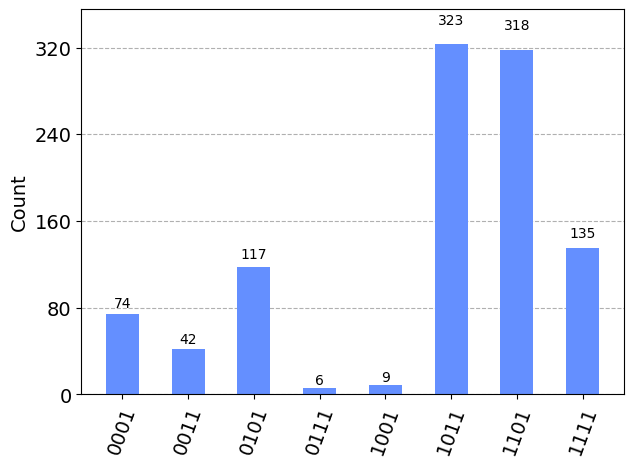

In [156]:
N = 4
nnqw = prepare_nn(N, verbose=True)
# nnqw.draw('mpl', style='clifford')
nnqw.measure([i for i in range(N)], [i for i in range(N)])
backend = BasicAer.get_backend('qasm_simulator')
circuit_compiled = transpile(nqw, backend)
simulator = backend.run(circuit_compiled, shots=1024)
result = simulator.result()
counts = result.get_counts(circuit_compiled)
plot_histogram(counts)

## Naive implementation vs. Nearest Neighbor - Gate depth analysis